<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg" 
     width="30%" 
     align=right
     alt="Dask logo">


## Ejecución de codigo pandas en paralelo

*Though you don't really need to do this, because dask.dataframe does most of it for you*

### Datos financieros en multiples archivos CSV

In [1]:
!head data/minute/aapl/2012-01-03T00:00:00.csv

timestamp,close,high,low,open
2012-01-03 09:00:00,398.391,398.391,397.88,398.065
2012-01-03 09:02:00,398.904,398.904,398.482,398.482
2012-01-03 09:04:00,398.879,398.879,398.613,398.799
2012-01-03 09:06:00,399.191,399.202,399.0,399.0
2012-01-03 09:08:00,399.018,399.07,398.935,399.07
2012-01-03 09:10:00,398.799,398.96,398.799,398.96
2012-01-03 09:12:00,398.86,398.86,398.69,398.78
2012-01-03 09:14:00,399.203,399.203,398.871,398.871
2012-01-03 09:16:00,399.353,399.391,399.318,399.318


In [2]:
from glob import glob

filenames = sorted(glob('data/minute/aapl/2012-*.csv'))
len(filenames)

250

In [3]:
len(filenames)

250

### Use Pandas on one file

In [3]:
import pandas as pd

df = pd.read_csv(filenames[0], parse_dates=['timestamp'])
df.head()

,timestamp,close,high,low,open
0,2012-01-03 09:00:00,398.391,398.391,397.880,398.065
1,2012-01-03 09:02:00,398.904,398.904,398.482,398.482
2,2012-01-03 09:04:00,398.879,398.879,398.613,398.799
3,2012-01-03 09:06:00,399.191,399.202,399.000,399.000
4,2012-01-03 09:08:00,399.018,399.070,398.935,399.070


In [4]:
df.close.mean()

398.5203112033194

In [5]:
df.groupby(df.timestamp.dt.hour).close.mean()

timestamp
9     398.996900
10    398.860200
11    398.220767
12    397.041733
13    397.896533
14    398.194200
15    399.501600
16    399.416467
17    399.543000
Name: close, dtype: float64

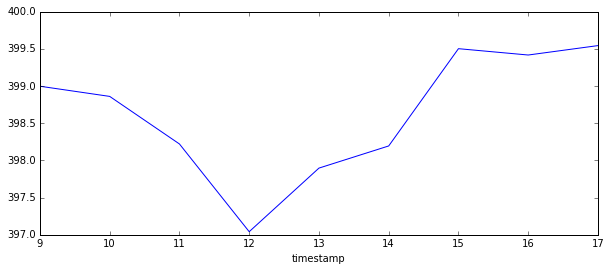

In [6]:
%matplotlib inline
(df.groupby(df.timestamp.dt.hour)
   .close
   .mean()
   .plot(figsize=(10, 4)))

In [8]:
# Hay mas de un archivo 
#!ls data/minute/aapl/

### Dask,dataframe puede hacer todo esto sobre todos los archivos csv

In [10]:
import dask.dataframe as dd

df = dd.read_csv('data/minute/aapl/*.csv', parse_dates=['timestamp'])
df.close.mean().compute()

397.7775601110766

### Use Pandas and a for loop on many CSV files

In [11]:
from dask import delayed

# Definimos la operacion, solo la declaramos, el computo se hara 
# hasta que se lo especifiquemos
dfs = []
for fn in filenames[:10]:
    # Agregamos operaciones read_csv
    df = delayed( pd.read_csv)(fn, parse_dates=['timestamp'])    
    dfs.append(df)

# Mas operaciones, sums u counts sobre el 
# pandas.dataframe df
sums = []
counts = []
for df in dfs:
    sums.append(df.close.sum())
    counts.append(df.close.count())

# Resultado acumulado y reducido, entrga objeto delayed    
result = delayed(sum)(sums) / delayed(sum)(counts)
result

Delayed('truediv-6d26699493ff9ce311341a5fab2effca')

### Paralelizamos la operacion con Dask.delayed

**¡IMPORTANTE!**
Solo usaremos los primeros 10 archivos para producir una visualizacion
razonable

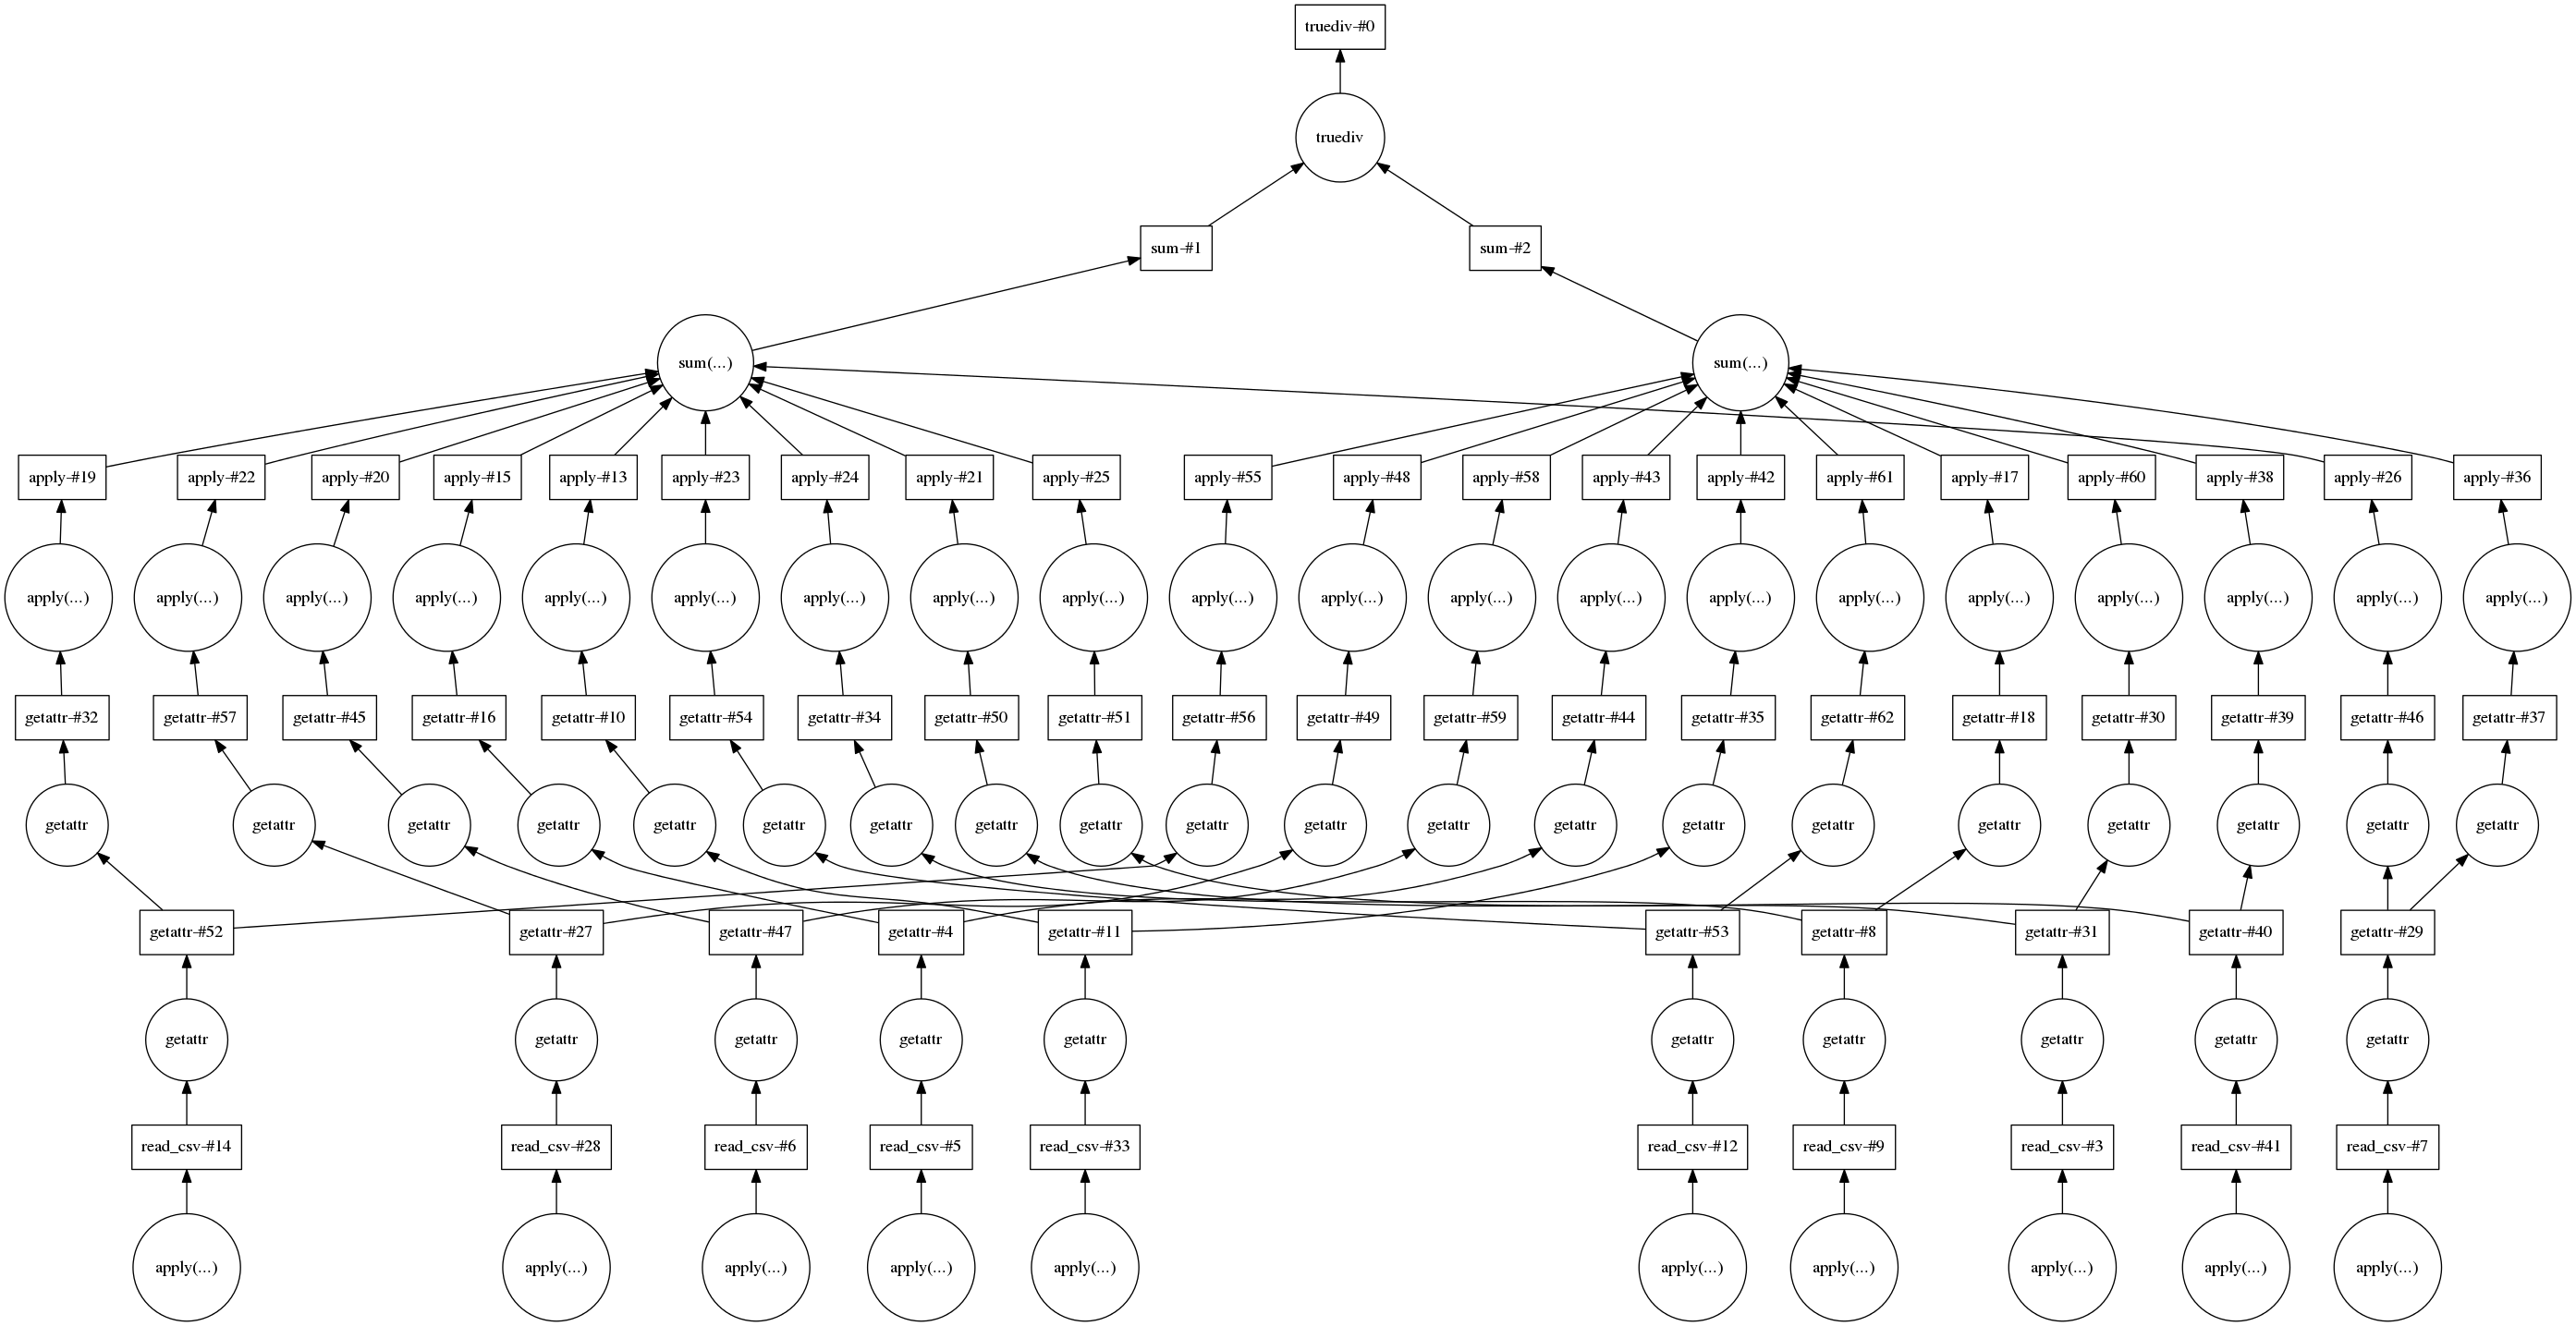

In [12]:
result.visualize()

In [13]:
result.compute()

408.04368506224063

### Estos algoritmos ya existen en dask.dataframe

In [14]:
import dask.dataframe as dd

df = dd.read_csv('data/minute/aapl/2012-*.csv', 
                 parse_dates=['timestamp'])
df

dd.DataFrame<from-de..., npartitions=250>

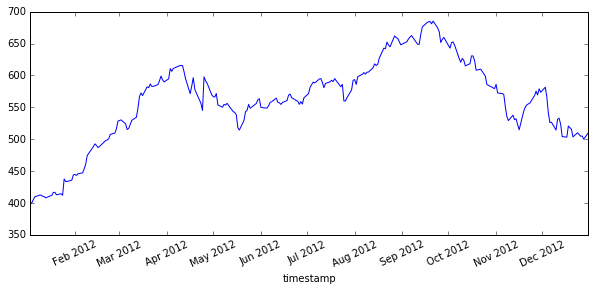

In [15]:
%matplotlib inline
result = (df.groupby(df.timestamp.dt.date)
            .close
            .mean()
            .compute()
            .plot(figsize=(10, 4), rot=25))

## Series de tiempo

In [16]:
df = dd.read_csv('data/minute/aapl/2012-01-0*.csv', 
                 parse_dates=['timestamp'])

# Lo siento, no tan eficiente
df = df.set_index(df.timestamp).compute()

In [20]:
df.head()

,timestamp,close,high,low,open
timestamp,,,,,
2012-01-03 09:00:00,2012-01-03 09:00:00,398.391,398.391,397.880,398.065
2012-01-03 09:02:00,2012-01-03 09:02:00,398.904,398.904,398.482,398.482
2012-01-03 09:04:00,2012-01-03 09:04:00,398.879,398.879,398.613,398.799
2012-01-03 09:06:00,2012-01-03 09:06:00,399.191,399.202,399.000,399.000
2012-01-03 09:08:00,2012-01-03 09:08:00,399.018,399.070,398.935,399.070


In [18]:
(df.close
   .rolling(10)
   .mean()
   .visualize(rankdir="LR"))

AttributeError: 'Series' object has no attribute 'visualize'

In [21]:
(df.close
   .resample(rule=pd.Timedelta(hours=4))
   .mean()
   .visualize(rankdir="LR"))

AttributeError: 'Series' object has no attribute 'visualize'

### Minimizar el uso de memoria

In [ ]:
# Carga en la lista df, todos los archivos!!
dfs = []
for fn in filenames:
    dfs.append(pd.read_csv(fn, parse_dates=['timestamp']))
    
sums = []
counts = []
for df in dfs:
    sums.append(df.close.sum())
    counts.append(df.close.count())
    
sum(sums) / sum(counts)

In [ ]:
sums = []
counts = []

# Carga un archivo csv en cada ciclo, minimizamos el uso de memoria..
for fn in filenames:
    df = pd.read_csv(fn, parse_dates=['timestamp'])
    sums.append(df.close.sum())
    counts.append(df.close.count())
    
sum(sums) / sum(counts)